# RNN Exercises
Wir werden Daten von der Federal Reserve Economic Database (FRED) beziehen. Hierbei handelt es sich um Strom- und Gaserzeugung von Januar 1992 bis Januar 2019 (insgesamt 325 records).

Quelle: https://fred.stlouisfed.org/series/IPG2211A2N

Wir werden folgendes üben:
* Frameworks & Libraries Importieren, sowie Daten 
* Daten für das Modell vorbereiten/formen
* LSTM Modell definieren sowie die dazugehörigen Datasets
* Modell trainieren
* Modell Evaluieren
* Ergebnisse Plotten

## 1 Voraussetzungen Importieren

In [170]:
# folgendes ausführen

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Daten aus der 'data.csv'-Datei einlesen
df = pd.read_csv('data.csv', index_col=0, parse_dates=True)

# Entferne Zeilen mit fehlenden Werten
df.dropna(inplace=True)

# Ausgabe der Anzahl der verbleibenden Datensätze
print(len(df))

# Zeige die ersten Datensätze des DataFrames an
df.head()


1013


,IPG2211A2N
DATE,
1939-01-01,3.3336
1939-02-01,3.3591
1939-03-01,3.4354
1939-04-01,3.4609
1939-05-01,3.4609


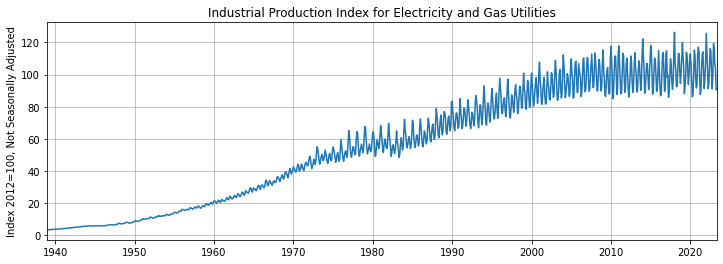

In [171]:
# Ausführen um Daten zu plotten
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

## 2. Datenvorbereitung

In [172]:
# Aufgabe: Wir werden mit einem Window- und Testsize von 12 arbeiten

# Die abhängige Variable (Zielvariable) aus dem DataFrame extrahieren und zu float-Werten konvertieren
y = df['IPG2211A2N'].values.astype(float)

# Größe des Testsets definieren
test_size = 48

# Größe des Fensters definieren
window_size = 24

# Trainingsdatensatz erstellen
train_set = y[:-test_size]

# Testdatensatz erstellen
test_set = y[-test_size:]


In [173]:
# Ausführen um Ergebnisse zu prüfen:

print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

# Als Ergebnis sollten Sie Train:313 und Test:12 haben. # Train: 1001 Test:  12 --> Maybe Unterscheidung hinsichtlich der Aktualität?

Train: 965
Test:  48


## 3. Trainingsdaten Normalisieren

In [174]:
# Ausführen um die Features zu skalieren innerhalb eines Ranges zwischen -1 und 1.

scaler = MinMaxScaler(feature_range=(-1, 1))

# Die Dimensionen des train_set anpassen
train_set_reshaped = train_set.reshape(-1, 1)

# Features skalieren
train_norm = scaler.fit_transform(train_set_reshaped)

print(f'Erstes Element, original: {train_set[0]}')
print(f'Erstes Element, skaliert: {train_norm[0]}')

Erstes Element, original: 3.3336
Erstes Element, skaliert: [-1.]


## 4. Datenvorbereitung für das LSTM

In [175]:
# Eine Liste von den Sequenziellen und gelabelten Windows wird für das LSTM Modell vorbereitet.

# Ausführen
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws): #ws = window size 
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

train_data = input_data(train_norm,window_size)

print(f'Train_data: {len(train_data)}')

# Ausführen um Ergebnise zu überprüfen
print(f'Train_data: {len(train_data)}')  

# Ergebnis sollte 301 sein


Train_data: 941
Train_data: 941


## 5. Modell Definieren

In [176]:
# Modell sollte 1 LSTM Layer haben (1, 64) sowie 1 Fully Connected Layer (64, 1)
# Nicht vergessen: h0 und c0 initialisieren!

class LSTMnetwork(nn.Module):
    def __init__(self):
        super(LSTMnetwork, self).__init__()
        # LSTM lazer hinzufügen 
        self.lstm = nn.LSTM(1, 64)

        #fc layer hinzufügen
        self.fc = nn.Linear(64, 1)
        
        #h0 c0 initialisieren
        self.hidden = (torch.zeros(1,1,64),
                       torch.zeros(1,1,64))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1, -1), self.hidden)
        pred = self.fc(lstm_out.view(len(seq), -1))
        return pred[-1]
        

# Setzen der Zufallssaat für Reproduzierbarkeit
torch.manual_seed(101)

# Instanziierung des LSTM-Netzwerk-Modells
model = LSTMnetwork()
model 

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

## 6. Loss und Optimization Funktionen

In [177]:
import torch.optim as optim

# MSELoss als Kriterium definieren
criterion = nn.MSELoss()

# Adam-Optimizer mit Lernrate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)


## 7. Modell Trainieren

In [178]:
epochs = 5

for i in range(epochs):
    for seq, y_train in train_data:
        # Setzen der Modellparameter und der versteckten Zustände zurück
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, 64),
                        torch.zeros(1, 1, 64))

        # Anwenden des Modells
        y_pred = model(seq.view(-1, 1, 1))

        # Berechnung des Verlusts und Aktualisierung der Modellparameter
        loss = criterion(y_pred[-1], y_train)  # Verwendung der letzten Vorhersage für die Verlustberechnung
        loss.backward()
        optimizer.step()

    # Optional, aber wir möchten die Fortschritte sehen
    print(f'{i+1} von {epochs} Epochen abgeschlossen')


c:\Users\Simon Heiß\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1 von 5 Epochen abgeschlossen
2 von 5 Epochen abgeschlossen
3 von 5 Epochen abgeschlossen
4 von 5 Epochen abgeschlossen
5 von 5 Epochen abgeschlossen


## 8. Modell Evaluation mittels Test Datensatz

In [186]:
future = 72
preds = train_norm[-window_size:].tolist()

for i in range(future):
    # Vorhersage für den nächsten Zeitschritt generieren
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, 64),
                        torch.zeros(1, 1, 64))
        pred = model(seq).item()
        preds.append(pred)

# Um die Ergebnisse zu sehen
preds[window_size:]


[0.6786391735076904,
 0.8532459735870361,
 0.835138201713562,
 0.6651419401168823,
 0.5091936588287354,
 0.515174925327301,
 0.6738371253013611,
 0.8198007345199585,
 0.8154677152633667,
 0.6790497303009033,
 0.5445177555084229,
 0.5398206114768982,
 0.6666890382766724,
 0.7929069995880127,
 0.7973371148109436,
 0.6860913634300232,
 0.5694602727890015,
 0.5587668418884277,
 0.6619541645050049,
 0.7716870307922363,
 0.7816747426986694,
 0.6902468800544739,
 0.5887722373008728,
 0.5744487047195435,
 0.6590666174888611,
 0.7547180652618408,
 0.7681876420974731,
 0.6926896572113037,
 0.6042172312736511,
 0.5877617597579956,
 0.6574069857597351,
 0.7408555746078491,
 0.756436288356781,
 0.6939976811408997,
 0.6167966723442078,
 0.5992187261581421,
 0.6566383838653564,
 0.7294549345970154,
 0.7461780309677124,
 0.69452965259552,
 0.6271507740020752,
 0.6091512441635132,
 0.6565011739730835,
 0.7200233340263367,
 0.737199604511261,
 0.6945151090621948,
 0.6357242465019226,
 0.6177973747253418

## 9. Ergebnisse Invertieren

In [187]:
# Folgendes ausführen
# Wieso invertieren wir unsere Ergebnisse hier?
# Mit scaler.inverse_transform werden die invertierten Vorhersagen zurückgewonnen. Da die ursprünglichen Daten mit dem MinMaxScaler skaliert wurden, müssen die Vorhersagen in ihren ursprünglichen Skalenwerten zurücktransformiert werden.
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[106.60323016],
       [117.34501431],
       [116.2310269 ],
       [105.77288238],
       [ 96.17896751],
       [ 96.54693413],
       [106.30780887],
       [115.28746822],
       [115.02090152],
       [106.62848755],
       [ 98.35210064],
       [ 98.06313304],
       [105.86805963],
       [113.63296968],
       [113.9055097 ],
       [107.06168776],
       [ 99.88656056],
       [ 99.2287023 ],
       [105.57677091],
       [112.32752038],
       [112.94196292],
       [107.31733452],
       [101.07462972],
       [100.19344815],
       [105.39912945],
       [111.28359217],
       [112.11223851],
       [107.46761381],
       [102.02480344],
       [101.0124653 ],
       [105.29702915],
       [110.43077382],
       [111.38929699],
       [107.54808324],
       [102.79868876],
       [101.71729615],
       [105.24974488],
       [109.72940816],
       [110.75821054],
       [107.58081005],
       [103.43567154],
       [102.32834317],
       [105.24130375],
       [109

## 10. Ergebnisse Plotten

72 72


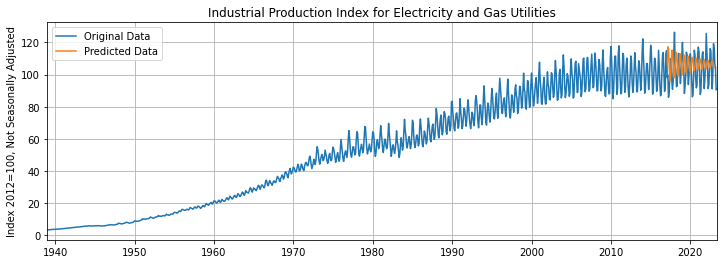

In [188]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange('2017-02-01', '2023-02-01', dtype='datetime64[M]').astype('datetime64[D]')
true_predictions = true_predictions[:len(x)]
print(len(true_predictions),len(x))
plt.figure(figsize=(12, 4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['IPG2211A2N'], label='Original Data')
plt.plot(x, true_predictions, label='Predicted Data')
plt.legend()
plt.show()


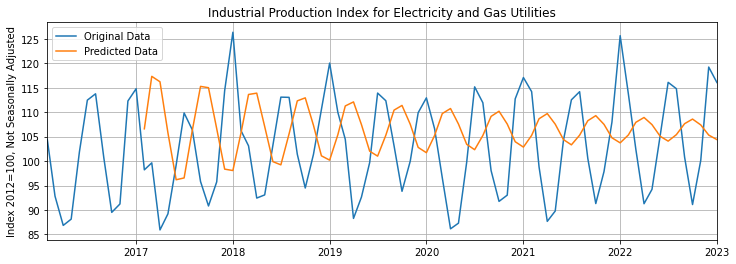

In [190]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df[(df.index >= '2016-02-01') & (df.index < '2023-02-01')], label='Original Data')
plt.plot(x, true_predictions, label='Predicted Data')
plt.legend()
plt.show()
